In [ ]:
!pip install optuna

In [ ]:
# To install scikit learn 1.1.1
!pip install scikit-learn==1.1.1

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
sns.set_theme()

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Imports

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)

import pandas as pd
import util.common as util
from sklearn.preprocessing import QuantileTransformer, MinMaxScaler
from sklearn.metrics import auc, roc_curve, accuracy_score, balanced_accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.ensemble import RandomForestClassifier
import pathlib
import pickle
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from util.AUROCEarlyStoppingPruneCallback import AUROCEarlyStoppingPruneCallback

#Teste - Detecção de Anomalias com OCSVM (Importado) + RF (Importado) + Extensão

In [ ]:
test = pd.read_parquet("data/test.parquet")
# test = pd.read_csv("data/test.csv")

y = test["Y"].replace(["Heartbleed", "Infiltration"], "Unknown")
x = test.drop(columns=['Y'])

y.value_counts()

,count
Y,
Benign,56468
(D)DOS,584
Port Scan,584
Botnet,584
Brute Force,584
Web Attack,584
Unknown,47


In [ ]:
f = open("models/stage1_ocsvm.p","rb")
model_iforest = pickle.load(f)
f.close()

In [ ]:
tau_b = -0.0002196942507948895
tau_m = 0.98
tau_u = 0.0040588613744241275

In [ ]:
proba_1 = -model_iforest.decision_function(x) # invert sign to act as anomaly score
pred_1 = np.where(proba_1 > tau_b, "Attack", "Benign").astype(object)
np.unique(pred_1, return_counts=True)

(array(['Attack', 'Benign'], dtype=object), array([20541, 38894]))

In [ ]:
y_true = y.apply(lambda c: 'Benign' if c == 'Benign' else 'Attack')
y_pred = pd.Series(proba_1 > tau_b).apply(lambda c: 'Benign' if c == 0 else 'Attack')

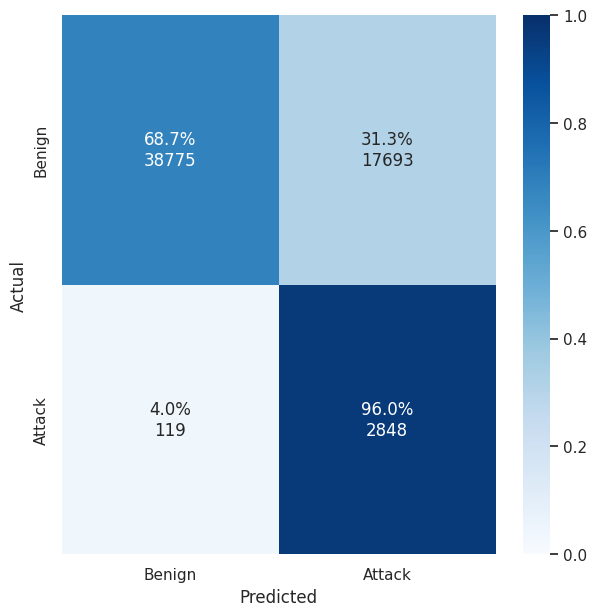

In [ ]:
classes = ['Benign', 'Attack']
util.plot_confusion_matrix(y_true, y_pred, values=classes, labels=classes)

In [ ]:
f = open("models/stage2_rf.p","rb")
stage2 = pickle.load(f)
f.close()

In [ ]:
proba_2 = stage2.predict_proba(x[pred_1 == "Attack"])
pred_2 = np.where(
    np.max(proba_2, axis=1) > tau_m,
    stage2.classes_[np.argmax(proba_2, axis=1)],
    "Unknown")
np.unique(pred_2, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([  547,   746,   570,   594, 17543,   541]))

In [ ]:
proba_3 = proba_1[pred_1 == "Attack"][pred_2 == "Unknown"]
pred_3 = np.where(proba_3 < tau_u, "Benign", "Unknown")
np.unique(pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([16955,   588]))

In [ ]:
y_pred = pred_1.copy()
y_pred[y_pred == "Attack"] = pred_2
y_pred[y_pred == "Unknown"] = pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  547, 55849,   746,   570,   594,   588,   541]))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, figsize=(7,7), cmap="Blues", values=[-1, 1], labels=["Attack", "Benign"], title="", ax=None, metrics=False):
    cm = confusion_matrix(y_true, y_pred, labels=values)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.1f%%\n%d' % (p * 100, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, cmap=cmap, annot=annot, fmt='', ax=ax, vmin=0, vmax=1)
    if title != "":
        ax.set_title(title)

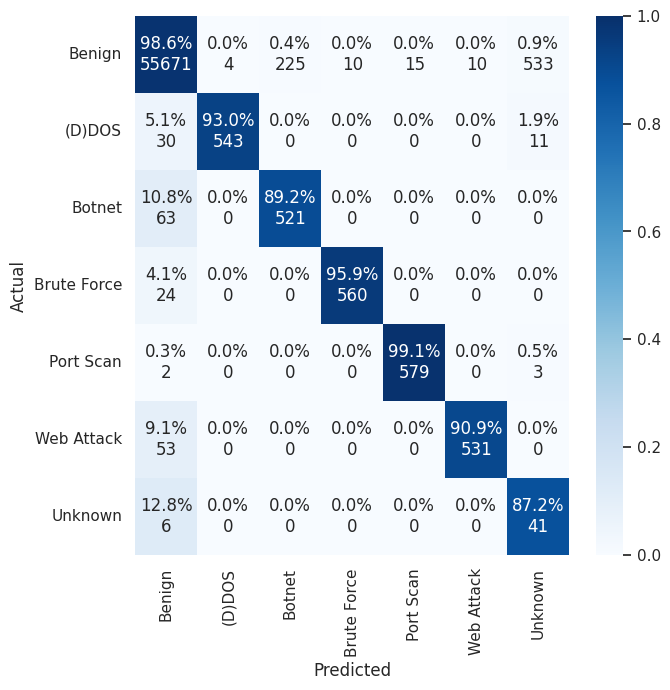

In [ ]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
plot_confusion_matrix(y, y_pred, values=classes, labels=classes, metrics=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, digits=4))

              precision    recall  f1-score   support

      (D)DOS     0.9927    0.9298    0.9602       584
      Benign     0.9968    0.9859    0.9913     56468
      Botnet     0.6984    0.8921    0.7835       584
 Brute Force     0.9825    0.9589    0.9705       584
   Port Scan     0.9747    0.9914    0.9830       584
     Unknown     0.0697    0.8723    0.1291        47
  Web Attack     0.9815    0.9092    0.9440       584

    accuracy                         0.9834     59435
   macro avg     0.8138    0.9342    0.8231     59435
weighted avg     0.9926    0.9834    0.9875     59435



#Teste - Detecção de Anomalias com Isolation Forest + RF (Importado) + Extensão

In [ ]:
test = pd.read_parquet("data/test.parquet")
# test = pd.read_csv("data/test.csv")

y = test["Y"].replace(["Heartbleed", "Infiltration"], "Unknown")
x = test.drop(columns=['Y'])

y.value_counts()

,count
Y,
Benign,56468
(D)DOS,584
Port Scan,584
Botnet,584
Brute Force,584
Web Attack,584
Unknown,47


In [ ]:
f = open("models/stage1_IsolationForest_ST.p","rb")
model_iforest = pickle.load(f)
f.close()

In [ ]:
tau_b = -0.122349
tau_m = 0.98
tau_u = 0.06766017781741557

In [ ]:
proba_1 = -model_iforest.decision_function(x) # invert sign to act as anomaly score
pred_1 = np.where(proba_1 > tau_b, "Attack", "Benign").astype(object)
np.unique(pred_1, return_counts=True)

(array(['Attack', 'Benign'], dtype=object), array([30289, 29146]))

In [ ]:
y_true = y.apply(lambda c: 'Benign' if c == 'Benign' else 'Attack')
y_pred = pd.Series(proba_1 > tau_b).apply(lambda c: 'Benign' if c == 0 else 'Attack')

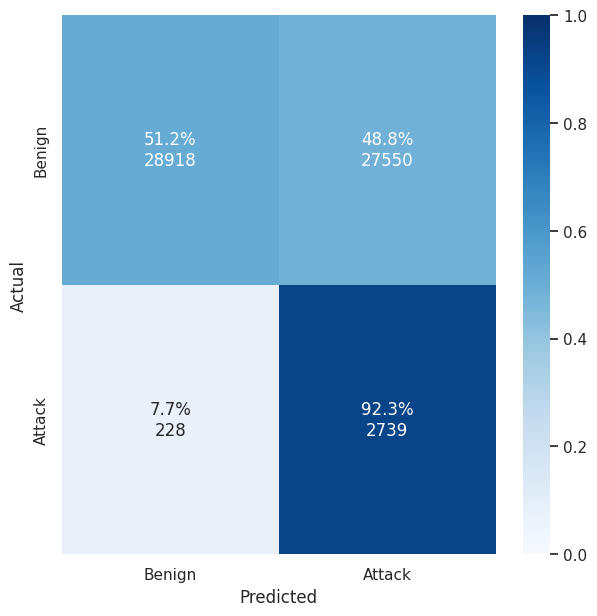

In [ ]:
classes = ['Benign', 'Attack']
util.plot_confusion_matrix(y_true, y_pred, values=classes, labels=classes)

In [ ]:
f = open("models/stage2_rf.p","rb")
stage2 = pickle.load(f)
f.close()

In [ ]:
proba_2 = stage2.predict_proba(x[pred_1 == "Attack"])
pred_2 = np.where(
    np.max(proba_2, axis=1) > tau_m,
    stage2.classes_[np.argmax(proba_2, axis=1)],
    "Unknown")
np.unique(pred_2, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Unknown',
        'Web Attack'], dtype=object),
 array([  568,   553,   570,   594, 27463,   541]))

In [ ]:
proba_3 = proba_1[pred_1 == "Attack"][pred_2 == "Unknown"]
pred_3 = np.where(proba_3 < tau_u, "Benign", "Unknown")
np.unique(pred_3, return_counts=True)

(array(['Benign', 'Unknown'], dtype='<U7'), array([26949,   514]))

In [ ]:
y_pred = pred_1.copy()
y_pred[y_pred == "Attack"] = pred_2
y_pred[y_pred == "Unknown"] = pred_3
np.unique(y_pred, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([  568, 56095,   553,   570,   594,   514,   541]))

In [ ]:
def plot_confusion_matrix(y_true, y_pred, figsize=(7,7), cmap="Blues", values=[-1, 1], labels=["Attack", "Benign"], title="", ax=None, metrics=False):
    cm = confusion_matrix(y_true, y_pred, labels=values)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float)
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            annot[i, j] = '%.1f%%\n%d' % (p * 100, c)
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, cmap=cmap, annot=annot, fmt='', ax=ax, vmin=0, vmax=1)
    if title != "":
        ax.set_title(title)

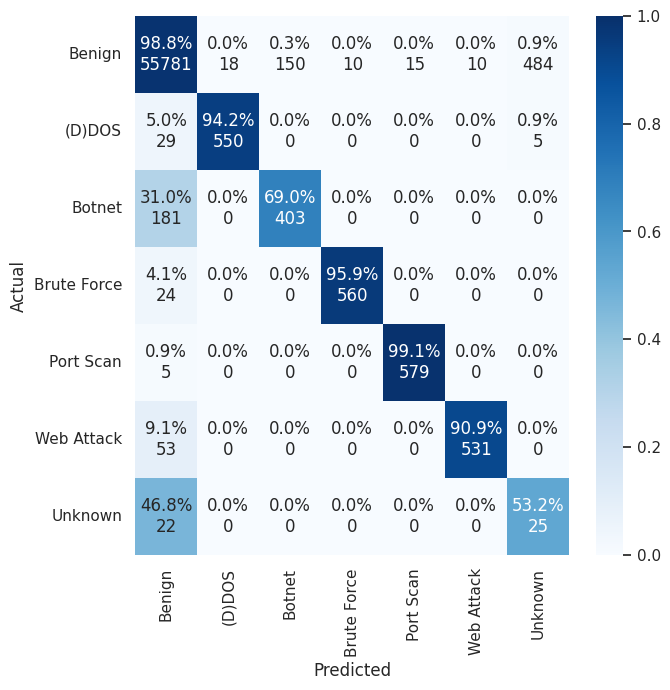

In [ ]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
plot_confusion_matrix(y, y_pred, values=classes, labels=classes, metrics=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred, digits=4))

              precision    recall  f1-score   support

      (D)DOS     0.9683    0.9418    0.9549       584
      Benign     0.9944    0.9878    0.9911     56468
      Botnet     0.7288    0.6901    0.7089       584
 Brute Force     0.9825    0.9589    0.9705       584
   Port Scan     0.9747    0.9914    0.9830       584
     Unknown     0.0486    0.5319    0.0891        47
  Web Attack     0.9815    0.9092    0.9440       584

    accuracy                         0.9831     59435
   macro avg     0.8113    0.8587    0.8059     59435
weighted avg     0.9904    0.9831    0.9865     59435

